In [1]:
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 51.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole     # 화면에 출력하기 위한 옵션
IPythonConsole.ipython_useSVG=True

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

In [3]:
path = "drive/MyDrive/Colab Notebooks/data/"

In [4]:
df = pd.read_csv(path + "preprocessed_data.csv")
df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [5]:
fps = []
for i, smiles in enumerate(df["SMILES"]):
    mol = Chem.MolFromSmiles(smiles)
    arr = np.zeros((1,))
    # rdkit의 fingerprint 함수를 사용해서 분자의 특성 수치화
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2048)
    DataStructs.ConvertToNumpyArray(fp, arr)

    fps.append(arr)

df["fps"] = fps
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps,mol
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e0971daa420>
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e0971daa880>
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e0971da9fc0>
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e0971da9f50>
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e0971dabed0>


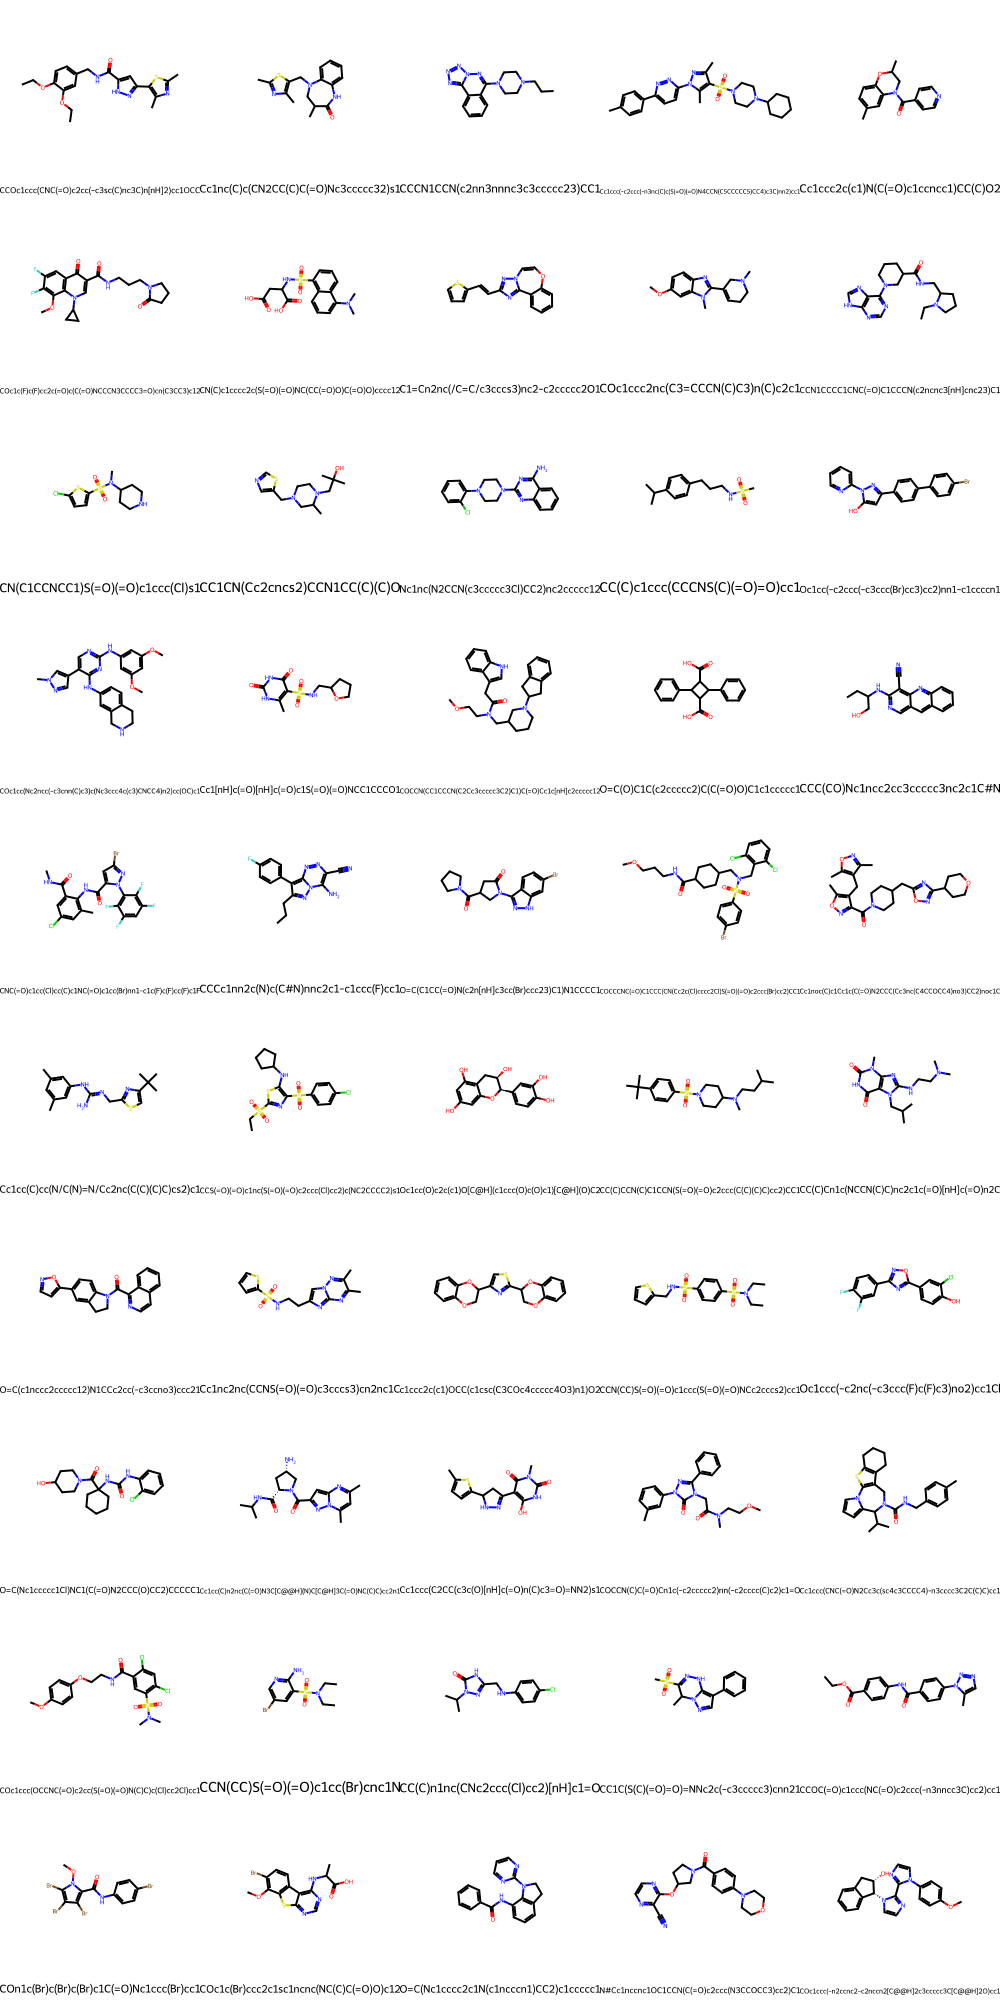

In [23]:
Draw.MolsToGridImage(df['mol'], molsPerRow=5, useSVG=True, legends=list(df['SMILES'][:].values))

In [6]:
idx_nan = df[df['AlogP'].isnull()].index

In [7]:
df_ = df.drop(idx_nan, axis=0)
df_.isnull().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
fps                           0
mol                           0
dtype: int64

In [30]:
df_.columns

Index(['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'fps', 'mol'],
      dtype='object')

In [8]:
yh_train = df_['HLM']
ym_train = df_['MLM']
x_train = df_['fps']

In [9]:
Xh_train, Xh_test, yh_train, yh_test = train_test_split(x_train, yh_train, test_size=0.2)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(x_train, ym_train, test_size=0.2)

In [33]:
Xh_train.shape, Xh_test.shape, yh_train.shape, yh_test.shape

((2788,), (697,), (2788,), (697,))

In [51]:
len(Xh_test.iloc[0])

2048

In [40]:
yh_test

100     99.900
1989    99.000
2088    24.025
3169    68.866
1902     9.210
         ...  
1790    56.500
1791    14.913
1729     2.846
3362    99.990
2183     4.440
Name: HLM, Length: 697, dtype: float64

In [10]:
def obj2float(X_train):
    return [i.astype(np.float32) for i in X_train]

In [11]:
Xh_train = obj2float(Xh_train)
Xh_test = obj2float(Xh_test)
Xm_train = obj2float(Xm_train)
Xm_test = obj2float(Xm_test)

In [12]:
def float2tensor(X_train):
    return torch.tensor(X_train)

In [13]:
Xh_train = float2tensor(Xh_train)
Xh_test = float2tensor(Xh_test)
yh_train = float2tensor(yh_train.values)
yh_test = float2tensor(yh_test.values)

Xm_train = float2tensor(Xm_train)
Xm_test = float2tensor(Xm_test)
ym_train = float2tensor(ym_train.values)
ym_test = float2tensor(ym_test.values)

In [14]:
def tensor2dataloader(X_train, y_train):
    return DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

In [15]:
h_train_dataloader = tensor2dataloader(Xh_train, yh_train)
h_test_dataloader = tensor2dataloader(Xh_test, yh_test)
m_train_dataloader = tensor2dataloader(Xm_train, ym_train)
m_test_dataloader = tensor2dataloader(Xm_test, ym_test)

In [16]:
# cpu나 gpu에서 모두 동작하게 만들기
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(2048, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.output = nn.Linear(256, 1)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.linear1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.batch_norm3(out)
        out = self.relu(out)
        out = self.output(out)
        return out

model = Model()
model.to(device)

Model(
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (batch_norm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [18]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.00001)

In [21]:
def training(train_dataloader, test_dataloader):
    # 전체 학습 데이터로 몇번 학습 시킬 것이냐를 결정
    epochs = 501

    # 손실 값을 저장하기 위한 변수 정의
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_train_loss = 0.0
        for i, data in enumerate(train_dataloader):
            x, y = data[0].to(device), data[1].to(device)
    ### model, data 둘 다 GPU 에 올려야 한다.

            x = x.to(torch.float32)
            y = y.to(torch.float32)

            optimizer.zero_grad()

            outputs = model(x)
            train_loss = loss_fn(outputs, y.view(-1, 1))
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()

        model.eval()
        epoch_val_loss = 0.0
        with torch.inference_mode():
            for i, data in enumerate(test_dataloader):
                x, y = data[0].to(device), data[1].to(device)

                x = x.to(torch.float32)
                y = y.to(torch.float32)

                outputs = model(x)
                val_loss = loss_fn(outputs, y.view(-1, 1))
                epoch_val_loss += val_loss.item()

        epoch_train_loss /= len(train_dataloader)
        epoch_val_loss /= len(test_dataloader)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        if epoch % 10 == 0:
            print("[Epoch %d] Train Loss: %.3f  Validation Loss: %.3f" %
                (epoch, epoch_train_loss, epoch_val_loss))
    return model, train_losses, val_losses

In [22]:
h_model, h_train_losses, h_val_losses = training(h_train_dataloader, h_test_dataloader)

  0%|          | 1/501 [00:00<02:46,  3.01it/s]

[Epoch 0] Train Loss: 4076.021  Validation Loss: 4063.996


  2%|▏         | 11/501 [00:03<02:33,  3.19it/s]

[Epoch 10] Train Loss: 3931.318  Validation Loss: 3934.917


  4%|▍         | 21/501 [00:07<03:41,  2.17it/s]

[Epoch 20] Train Loss: 3651.980  Validation Loss: 3813.157


  6%|▌         | 31/501 [00:11<03:04,  2.54it/s]

[Epoch 30] Train Loss: 3471.310  Validation Loss: 3758.666


  8%|▊         | 41/501 [00:14<02:23,  3.20it/s]

[Epoch 40] Train Loss: 3302.712  Validation Loss: 3678.559


 10%|█         | 51/501 [00:17<02:23,  3.14it/s]

[Epoch 50] Train Loss: 3081.685  Validation Loss: 3608.806


 12%|█▏        | 61/501 [00:20<02:18,  3.18it/s]

[Epoch 60] Train Loss: 2925.990  Validation Loss: 3639.882


 14%|█▍        | 71/501 [00:24<02:41,  2.66it/s]

[Epoch 70] Train Loss: 2771.442  Validation Loss: 3547.384


 16%|█▌        | 81/501 [00:27<02:13,  3.14it/s]

[Epoch 80] Train Loss: 2612.086  Validation Loss: 3490.994


 18%|█▊        | 91/501 [00:31<02:37,  2.60it/s]

[Epoch 90] Train Loss: 2443.160  Validation Loss: 3412.809


 20%|██        | 101/501 [00:34<02:09,  3.08it/s]

[Epoch 100] Train Loss: 2258.617  Validation Loss: 3308.980


 22%|██▏       | 111/501 [00:38<02:28,  2.63it/s]

[Epoch 110] Train Loss: 2098.963  Validation Loss: 3303.945


 24%|██▍       | 121/501 [00:41<02:02,  3.11it/s]

[Epoch 120] Train Loss: 1923.273  Validation Loss: 3084.704


 26%|██▌       | 131/501 [00:45<01:55,  3.20it/s]

[Epoch 130] Train Loss: 1781.634  Validation Loss: 3107.102


 28%|██▊       | 141/501 [00:48<01:54,  3.15it/s]

[Epoch 140] Train Loss: 1594.481  Validation Loss: 2855.471


 30%|███       | 151/501 [00:51<02:13,  2.63it/s]

[Epoch 150] Train Loss: 1448.968  Validation Loss: 2782.533


 32%|███▏      | 161/501 [00:55<01:48,  3.13it/s]

[Epoch 160] Train Loss: 1350.280  Validation Loss: 2978.231


 34%|███▍      | 171/501 [00:58<01:42,  3.20it/s]

[Epoch 170] Train Loss: 1204.436  Validation Loss: 2747.481


 36%|███▌      | 181/501 [01:01<01:40,  3.18it/s]

[Epoch 180] Train Loss: 1123.518  Validation Loss: 2804.003


 38%|███▊      | 191/501 [01:05<01:56,  2.66it/s]

[Epoch 190] Train Loss: 1009.701  Validation Loss: 2640.976


 40%|████      | 201/501 [01:10<02:15,  2.21it/s]

[Epoch 200] Train Loss: 916.655  Validation Loss: 2448.429


 42%|████▏     | 211/501 [01:14<02:01,  2.39it/s]

[Epoch 210] Train Loss: 850.704  Validation Loss: 2407.817


 44%|████▍     | 221/501 [01:18<02:02,  2.28it/s]

[Epoch 220] Train Loss: 761.976  Validation Loss: 2399.761


 46%|████▌     | 231/501 [01:22<01:34,  2.86it/s]

[Epoch 230] Train Loss: 687.615  Validation Loss: 2481.506


 48%|████▊     | 241/501 [01:25<01:22,  3.16it/s]

[Epoch 240] Train Loss: 643.206  Validation Loss: 2292.968


 50%|█████     | 251/501 [01:28<01:18,  3.20it/s]

[Epoch 250] Train Loss: 616.538  Validation Loss: 2200.190


 52%|█████▏    | 261/501 [01:31<01:17,  3.11it/s]

[Epoch 260] Train Loss: 576.155  Validation Loss: 2034.389


 54%|█████▍    | 271/501 [01:35<01:31,  2.52it/s]

[Epoch 270] Train Loss: 522.661  Validation Loss: 2081.612


 56%|█████▌    | 281/501 [01:38<01:08,  3.20it/s]

[Epoch 280] Train Loss: 480.692  Validation Loss: 2054.833


 58%|█████▊    | 291/501 [01:41<01:06,  3.17it/s]

[Epoch 290] Train Loss: 451.585  Validation Loss: 2174.386


 60%|██████    | 301/501 [01:45<01:09,  2.87it/s]

[Epoch 300] Train Loss: 419.601  Validation Loss: 1903.760


 62%|██████▏   | 311/501 [01:49<01:20,  2.36it/s]

[Epoch 310] Train Loss: 390.389  Validation Loss: 1868.474


 64%|██████▍   | 321/501 [01:53<00:59,  3.04it/s]

[Epoch 320] Train Loss: 391.932  Validation Loss: 1962.956


 66%|██████▌   | 331/501 [01:56<00:52,  3.23it/s]

[Epoch 330] Train Loss: 354.068  Validation Loss: 1933.621


 68%|██████▊   | 341/501 [01:59<00:52,  3.05it/s]

[Epoch 340] Train Loss: 313.808  Validation Loss: 1803.905


 70%|███████   | 351/501 [02:02<00:54,  2.76it/s]

[Epoch 350] Train Loss: 280.466  Validation Loss: 1786.422


 72%|███████▏  | 361/501 [02:06<00:48,  2.90it/s]

[Epoch 360] Train Loss: 254.776  Validation Loss: 1870.541


 74%|███████▍  | 371/501 [02:09<00:40,  3.19it/s]

[Epoch 370] Train Loss: 246.649  Validation Loss: 1885.115


 76%|███████▌  | 381/501 [02:12<00:37,  3.23it/s]

[Epoch 380] Train Loss: 203.394  Validation Loss: 1784.045


 78%|███████▊  | 391/501 [02:16<00:37,  2.94it/s]

[Epoch 390] Train Loss: 182.696  Validation Loss: 1662.589


 80%|████████  | 401/501 [02:20<00:37,  2.64it/s]

[Epoch 400] Train Loss: 159.310  Validation Loss: 1802.890


 82%|████████▏ | 411/501 [02:23<00:27,  3.24it/s]

[Epoch 410] Train Loss: 186.649  Validation Loss: 1775.812


 84%|████████▍ | 421/501 [02:26<00:25,  3.15it/s]

[Epoch 420] Train Loss: 144.336  Validation Loss: 1671.019


 86%|████████▌ | 431/501 [02:29<00:22,  3.13it/s]

[Epoch 430] Train Loss: 163.980  Validation Loss: 1739.898


 88%|████████▊ | 441/501 [02:33<00:23,  2.54it/s]

[Epoch 440] Train Loss: 147.606  Validation Loss: 1613.055


 90%|█████████ | 451/501 [02:36<00:16,  3.06it/s]

[Epoch 450] Train Loss: 100.644  Validation Loss: 1545.568


 92%|█████████▏| 461/501 [02:39<00:12,  3.19it/s]

[Epoch 460] Train Loss: 98.630  Validation Loss: 1618.118


 94%|█████████▍| 471/501 [02:43<00:09,  3.16it/s]

[Epoch 470] Train Loss: 91.387  Validation Loss: 1537.446


 96%|█████████▌| 481/501 [02:46<00:07,  2.59it/s]

[Epoch 480] Train Loss: 71.099  Validation Loss: 1511.817


 98%|█████████▊| 491/501 [02:50<00:03,  3.11it/s]

[Epoch 490] Train Loss: 69.620  Validation Loss: 1496.099


100%|██████████| 501/501 [02:53<00:00,  2.89it/s]

[Epoch 500] Train Loss: 73.397  Validation Loss: 1578.468


In [26]:
sns.set_style('whitegrid')

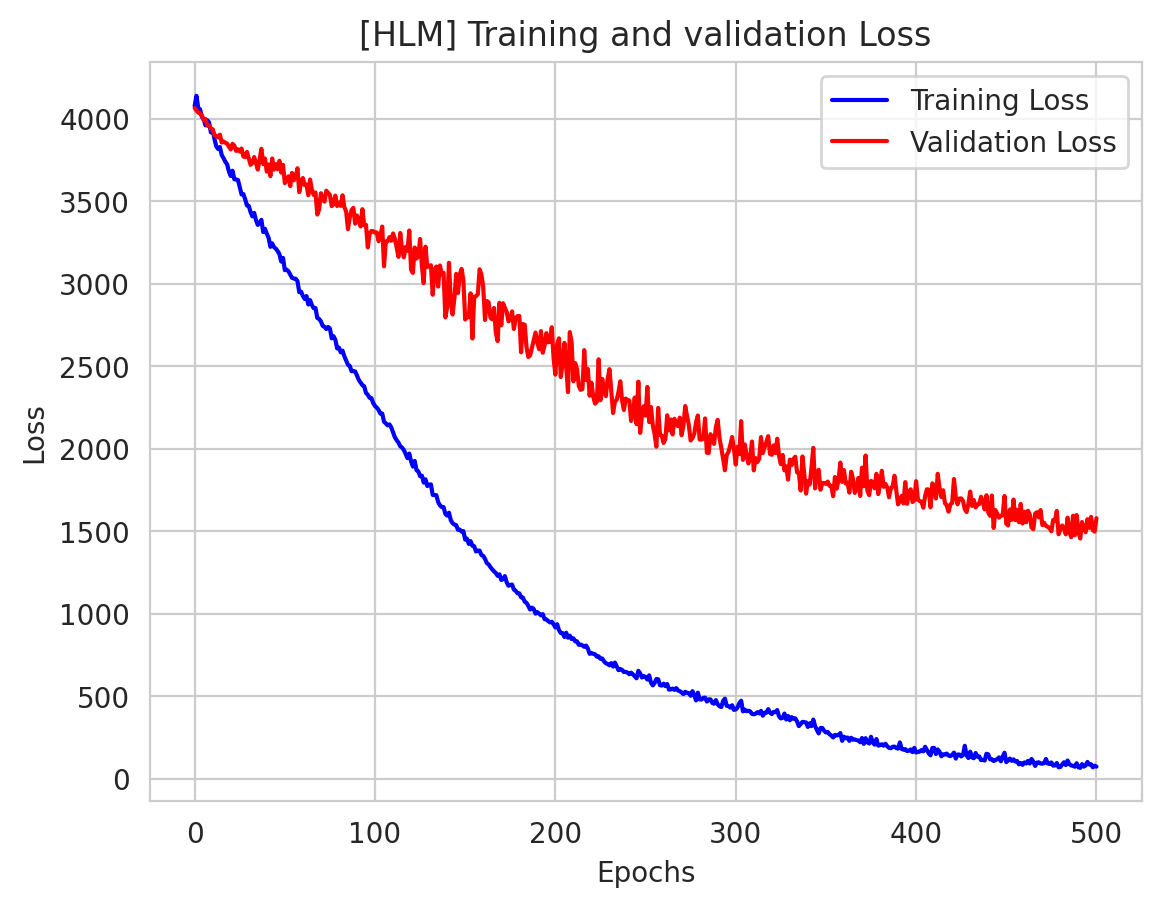

In [32]:
plt.plot(range(len(h_train_losses)), h_train_losses, 'b-', label='Training Loss')
plt.plot(range(len(h_val_losses)), h_val_losses, 'r-', label='Validation Loss')
plt.title('[HLM] Training and validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [23]:
m_model, m_train_losses, m_val_losses = training(m_train_dataloader,m_test_dataloader)

  0%|          | 1/501 [00:00<02:40,  3.11it/s]

[Epoch 0] Train Loss: 1132.566  Validation Loss: 986.253


  2%|▏         | 11/501 [00:03<02:33,  3.20it/s]

[Epoch 10] Train Loss: 357.861  Validation Loss: 766.390


  4%|▍         | 21/501 [00:07<03:08,  2.54it/s]

[Epoch 20] Train Loss: 176.979  Validation Loss: 789.855


  6%|▌         | 31/501 [00:10<02:28,  3.16it/s]

[Epoch 30] Train Loss: 131.592  Validation Loss: 922.165


  8%|▊         | 41/501 [00:13<02:23,  3.21it/s]

[Epoch 40] Train Loss: 94.129  Validation Loss: 812.190


 10%|█         | 51/501 [00:16<02:20,  3.20it/s]

[Epoch 50] Train Loss: 79.862  Validation Loss: 804.520


 12%|█▏        | 61/501 [00:20<02:48,  2.61it/s]

[Epoch 60] Train Loss: 79.967  Validation Loss: 800.433


 14%|█▍        | 71/501 [00:23<02:18,  3.10it/s]

[Epoch 70] Train Loss: 71.045  Validation Loss: 795.350


 16%|█▌        | 81/501 [00:26<02:12,  3.17it/s]

[Epoch 80] Train Loss: 69.916  Validation Loss: 796.723


 18%|█▊        | 91/501 [00:30<02:12,  3.10it/s]

[Epoch 90] Train Loss: 84.493  Validation Loss: 802.869


 20%|██        | 101/501 [00:33<02:35,  2.57it/s]

[Epoch 100] Train Loss: 68.475  Validation Loss: 812.483


 22%|██▏       | 111/501 [00:37<02:12,  2.94it/s]

[Epoch 110] Train Loss: 55.633  Validation Loss: 780.734


 24%|██▍       | 121/501 [00:40<01:59,  3.17it/s]

[Epoch 120] Train Loss: 50.749  Validation Loss: 774.775


 26%|██▌       | 131/501 [00:43<01:55,  3.21it/s]

[Epoch 130] Train Loss: 51.950  Validation Loss: 768.347


 28%|██▊       | 141/501 [00:47<02:11,  2.73it/s]

[Epoch 140] Train Loss: 65.144  Validation Loss: 772.687


 30%|███       | 151/501 [00:50<01:58,  2.94it/s]

[Epoch 150] Train Loss: 54.646  Validation Loss: 772.438


 32%|███▏      | 161/501 [00:53<01:45,  3.22it/s]

[Epoch 160] Train Loss: 66.261  Validation Loss: 776.759


 34%|███▍      | 171/501 [00:56<01:42,  3.22it/s]

[Epoch 170] Train Loss: 59.835  Validation Loss: 778.952


 36%|███▌      | 181/501 [01:00<01:51,  2.87it/s]

[Epoch 180] Train Loss: 54.761  Validation Loss: 773.571


 38%|███▊      | 191/501 [01:04<01:55,  2.69it/s]

[Epoch 190] Train Loss: 78.632  Validation Loss: 789.784


 40%|████      | 201/501 [01:07<01:34,  3.17it/s]

[Epoch 200] Train Loss: 49.760  Validation Loss: 796.660


 42%|████▏     | 211/501 [01:10<01:32,  3.15it/s]

[Epoch 210] Train Loss: 62.552  Validation Loss: 777.911


 44%|████▍     | 221/501 [01:13<01:27,  3.22it/s]

[Epoch 220] Train Loss: 71.731  Validation Loss: 782.996


 46%|████▌     | 231/501 [01:17<01:45,  2.56it/s]

[Epoch 230] Train Loss: 51.084  Validation Loss: 767.296


 48%|████▊     | 241/501 [01:20<01:22,  3.14it/s]

[Epoch 240] Train Loss: 51.503  Validation Loss: 785.319


 50%|█████     | 251/501 [01:23<01:18,  3.19it/s]

[Epoch 250] Train Loss: 57.323  Validation Loss: 790.880


 52%|█████▏    | 261/501 [01:26<01:15,  3.20it/s]

[Epoch 260] Train Loss: 75.663  Validation Loss: 817.100


 54%|█████▍    | 271/501 [01:30<01:26,  2.66it/s]

[Epoch 270] Train Loss: 42.856  Validation Loss: 781.044


 56%|█████▌    | 281/501 [01:33<01:10,  3.13it/s]

[Epoch 280] Train Loss: 65.858  Validation Loss: 791.135


 58%|█████▊    | 291/501 [01:36<01:05,  3.20it/s]

[Epoch 290] Train Loss: 42.341  Validation Loss: 771.102


 60%|██████    | 301/501 [01:40<01:02,  3.19it/s]

[Epoch 300] Train Loss: 63.262  Validation Loss: 795.519


 62%|██████▏   | 311/501 [01:43<01:11,  2.68it/s]

[Epoch 310] Train Loss: 48.218  Validation Loss: 826.851


 64%|██████▍   | 321/501 [01:47<01:09,  2.58it/s]

[Epoch 320] Train Loss: 59.867  Validation Loss: 791.251


 66%|██████▌   | 331/501 [01:51<00:54,  3.11it/s]

[Epoch 330] Train Loss: 57.815  Validation Loss: 829.298


 68%|██████▊   | 341/501 [01:54<00:50,  3.20it/s]

[Epoch 340] Train Loss: 46.580  Validation Loss: 784.137


 70%|███████   | 351/501 [01:57<00:55,  2.70it/s]

[Epoch 350] Train Loss: 47.251  Validation Loss: 794.253


 72%|███████▏  | 361/501 [02:01<00:44,  3.11it/s]

[Epoch 360] Train Loss: 63.042  Validation Loss: 850.600


 74%|███████▍  | 371/501 [02:04<00:41,  3.16it/s]

[Epoch 370] Train Loss: 47.674  Validation Loss: 821.266


 76%|███████▌  | 381/501 [02:07<00:37,  3.22it/s]

[Epoch 380] Train Loss: 67.866  Validation Loss: 804.982


 78%|███████▊  | 391/501 [02:10<00:40,  2.73it/s]

[Epoch 390] Train Loss: 59.611  Validation Loss: 831.165


 80%|████████  | 401/501 [02:14<00:33,  2.99it/s]

[Epoch 400] Train Loss: 58.726  Validation Loss: 834.155


 82%|████████▏ | 411/501 [02:17<00:27,  3.22it/s]

[Epoch 410] Train Loss: 42.802  Validation Loss: 784.187


 84%|████████▍ | 421/501 [02:20<00:24,  3.22it/s]

[Epoch 420] Train Loss: 36.601  Validation Loss: 794.665


 86%|████████▌ | 431/501 [02:23<00:23,  2.95it/s]

[Epoch 430] Train Loss: 48.591  Validation Loss: 813.037


 88%|████████▊ | 441/501 [02:27<00:21,  2.76it/s]

[Epoch 440] Train Loss: 48.058  Validation Loss: 793.051


 90%|█████████ | 451/501 [02:30<00:15,  3.21it/s]

[Epoch 450] Train Loss: 53.033  Validation Loss: 827.336


 92%|█████████▏| 461/501 [02:33<00:12,  3.22it/s]

[Epoch 460] Train Loss: 36.139  Validation Loss: 792.815


 94%|█████████▍| 471/501 [02:36<00:09,  3.20it/s]

[Epoch 470] Train Loss: 45.041  Validation Loss: 794.569


 96%|█████████▌| 481/501 [02:40<00:07,  2.58it/s]

[Epoch 480] Train Loss: 39.760  Validation Loss: 803.871


 98%|█████████▊| 491/501 [02:45<00:06,  1.59it/s]

[Epoch 490] Train Loss: 45.722  Validation Loss: 787.229


100%|██████████| 501/501 [02:56<00:00,  2.84it/s]

[Epoch 500] Train Loss: 34.402  Validation Loss: 800.269


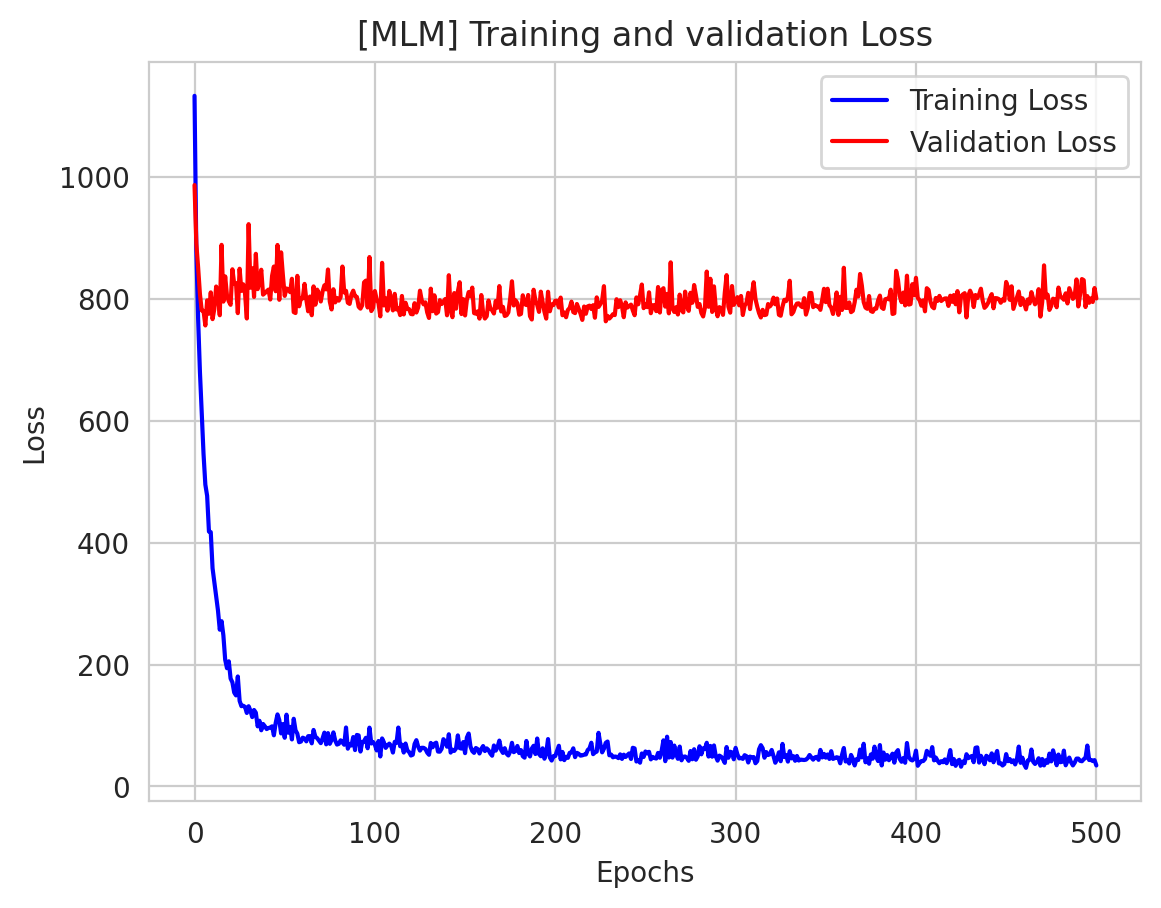

In [31]:
plt.plot(range(len(m_train_losses)), m_train_losses, 'b-', label='Training Loss')
plt.plot(range(len(m_val_losses)), m_val_losses, 'r-', label='Validation Loss')
plt.title('[MLM] Training and validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [33]:
mean_squared_error

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [36]:
test_df = pd.read_csv(path + 'test.csv')

In [37]:
fps = []
for i, smiles in enumerate(test_df["SMILES"]):
    mol = Chem.MolFromSmiles(smiles)
    arr = np.zeros((1,))
    # rdkit의 fingerprint 함수를 사용해서 분자의 특성 수치화
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2048)
    DataStructs.ConvertToNumpyArray(fp, arr)

    fps.append(arr)

test_df["fps"] = fps
test_df['mol'] = test_df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
test_df.head()

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps,mol
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.641,361.505,4,2,7,2.635,92.76,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e08f02fbd10>
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.585,370.399,5,0,3,0.585,68.31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e08f02fbe60>
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.276,347.414,4,4,5,4.290,92.86,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e08f02fbed0>
3,TEST_003,O=C(c1nc2ncccn2n1)N1CCCn2cc(-c3ccccc3)nc21,1.795,345.358,5,0,2,1.795,81.21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e08f02fbf40>
4,TEST_004,CCN1CCN(C(=O)c2cc3c(=O)n4cc(C)ccc4nc3n2C)CC1,1.219,353.418,4,0,2,0.169,61.15,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",<rdkit.Chem.rdchem.Mol object at 0x7e08f0330040>


In [38]:
test_df.isnull().sum()

id                            0
SMILES                        0
AlogP                         1
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
fps                           0
mol                           0
dtype: int64

In [41]:
idx_nan_ = test_df[test_df['AlogP'].isnull()].index

In [42]:
test_df_ = test_df.drop(idx_nan_, axis=0)
test_df_.isnull().sum()

id                            0
SMILES                        0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
fps                           0
mol                           0
dtype: int64

In [43]:
test_fps = test_df_['fps']

In [45]:
test_fps = obj2float(test_fps)
test_fps = float2tensor(test_fps)

In [52]:
def evaluation(model, test_df):
    model.eval()
    rmse = 0.0
    predictions = []
    with torch.inference_mode():
        outputs = model(test_df.to(device))
        preds = [output[0] for output in outputs.cpu().detach().numpy().tolist()]
        predictions += preds

    return predictions

In [53]:
evaluation(m_model, test_fps)

[9.370889663696289,
 77.87310791015625,
 55.88666915893555,
 18.60564613342285,
 52.054710388183594,
 78.77923583984375,
 43.47504425048828,
 46.083251953125,
 37.47835159301758,
 38.88264083862305,
 65.97157287597656,
 36.63782501220703,
 49.027164459228516,
 8.154687881469727,
 62.23562240600586,
 31.893003463745117,
 56.18708419799805,
 29.790395736694336,
 50.97865295410156,
 61.61314010620117,
 0.5218111276626587,
 1.9038169384002686,
 31.25429916381836,
 23.09346580505371,
 13.816427230834961,
 49.319950103759766,
 65.39197540283203,
 57.50321960449219,
 21.043493270874023,
 54.33157730102539,
 46.9921760559082,
 38.03140640258789,
 20.570972442626953,
 54.46182632446289,
 55.3783073425293,
 46.30086135864258,
 54.753662109375,
 52.49749755859375,
 1.1925698518753052,
 64.39783477783203,
 30.130887985229492,
 19.562055587768555,
 50.2940673828125,
 30.018999099731445,
 42.491336822509766,
 58.336307525634766,
 47.31141662597656,
 59.008216857910156,
 68.63919067382812,
 72.839042

In [ ]:
torch.save(obj=m_model.state_dict(), f="m_model.pth")
torch.save(obj=h_model.state_dict(), f="h_model.pth")

In [ ]:
m_model.load_state_dict(torch.load(f="m_model.pth"))
m_model.load_state_dict(torch.load(f="h_model.pth"))

In [58]:
df.to_csv('train_fps_mol.csv', index=False, encoding="utf-8-sig")
test_df.to_csv('test_fps_mol.csv', index=False, encoding="utf-8-sig")